<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Etv2_Project_Candidate_gene_Expression_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title load R
%load_ext rpy2.ipython

In [ ]:
#@title install R packages
%%R
install.packages("devtools")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("SummarizedExperiment", "SingleCellExperiment", "knitr", "LoomExperiment", "batchelor"))
devtools::install_github("immunogenomics/harmony")
devtools::install_github('theislab/kBET')
#devtools::install_version("spatstat", version = "1.64-1", repos = "http://cran.us.r-project.org")
#remotes::install_version("Seurat", version = "3.2.3")
remotes::install_github(repo = 'satijalab/seurat')
devtools::install_github('satijalab/seurat-wrappers')
devtools::install_github("cellgeni/sceasy")
install.packages("rliger")
remotes::install_github("rstudio/reticulate")
install.packages("SparseM")

In [4]:
#@title load library
%%R
library(Seurat)
library(SingleCellExperiment)
library(tidyverse)
library(magrittr)

In [5]:
#@title load and transform data to Seurat
%%R
system("wget -x -c -nH https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = readRDS(file = "gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = as(sce, "SingleCellExperiment")
rownames(sce) = rowData(sce)$name
colnames(sce)  = colData(sce)$barcodes
so = as.Seurat(sce, data = NULL)
so = CreateSeuratObject(counts = GetAssayData(so, slot = "counts"), meta.data = so@meta.data)
so[["percent.mt"]] = PercentageFeatureSet(so, pattern = "^mt-")
so[["percent.rpl"]] = PercentageFeatureSet(so, pattern = "^Rpl")
so[["percent.rps"]] = PercentageFeatureSet(so, pattern = "^Rps")
s.genes <- cc.genes$s.genes %>% str_to_title()
g2m.genes <- cc.genes$g2m.genes %>% str_to_title()
so <- CellCycleScoring(so, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
#normalize and scaling#
rownames(sce) = rownames(so)
colnames(sce) = colnames(so)
so <- SetAssayData(object = so, slot = "scale.data", new.data = assays(sce)$scaled_counts)
so <- SetAssayData(object = so, slot = "data", new.data = assays(sce)$normalized_counts)
#assign UMAP #
so[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(so@meta.data[,c("umap.V1", "umap.V2")]), key = "umap_", assay = DefaultAssay(so))
so

R[write to console]: Warning:
R[write to console]:  Non-unique features (rownames) present in the input matrix, making unique

R[write to console]: Warning:
R[write to console]:  Non-unique cell names (colnames) present in the input matrix, making unique

R[write to console]: Warning:
R[write to console]:  The following features are not present in the object: Mlf1ip, not searching for symbol synonyms

R[write to console]: Warning:
R[write to console]:  The following features are not present in the object: Fam64a, Hn1, not searching for symbol synonyms



An object of class Seurat 
17010 features across 15475 samples within 1 assay 
Active assay: RNA (17010 features, 0 variable features)
 1 dimensional reduction calculated: umap


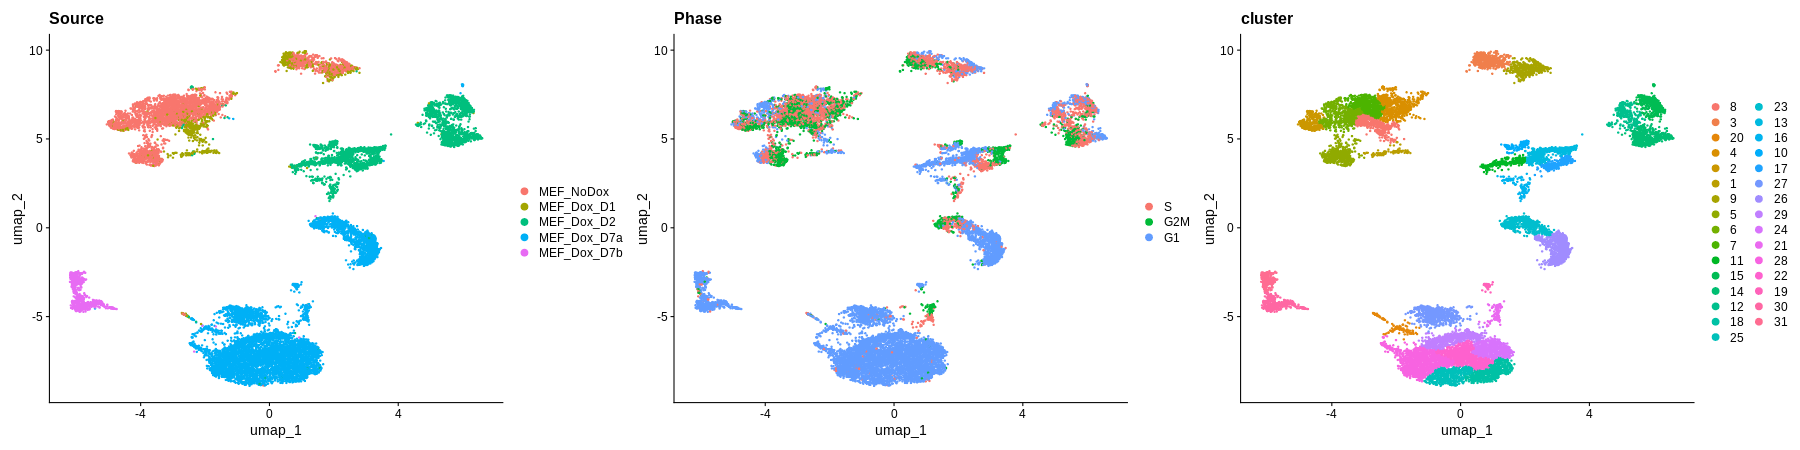

In [6]:
#@title plot UMAP
%%R -w 1800 -h 450
Seurat::Idents(so) = "group"
p1 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = TRUE, raster = FALSE) + ggplot2::ggtitle(label = "Source")
Seurat::Idents(so) = "Phase"
p2 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = FALSE, raster = FALSE) + ggplot2::ggtitle(label = "Phase")
Seurat::Idents(so) = "cluster"
p3 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = FALSE, raster = FALSE) + ggplot2::ggtitle(label = "cluster")
p1 + p2 + p3

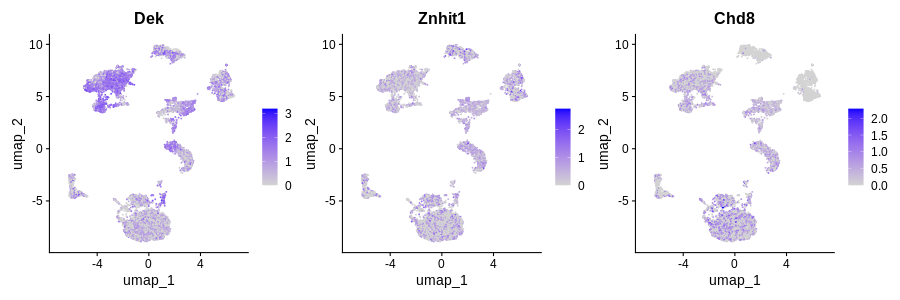

In [7]:
#@title UMAP plot expression of candidate genes
%%R -w 900 -h 300
Genes = c("Dek","Znhit1", "Chd8")
FeaturePlot(so, dims = c(1, 2), features = Genes, pt.size = 0.25, cols = c('lightgrey', "blue"), ncol = 3, raster = FALSE)

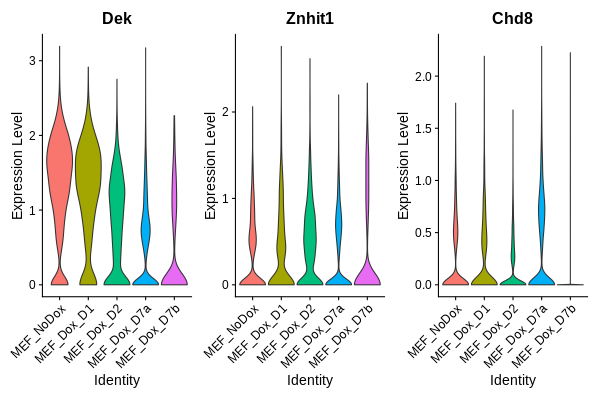

In [8]:
%%R -w 600 -h 400
Genes = c("Dek","Znhit1", "Chd8")
Idents(so) = "group"
VlnPlot(so, features = Genes, ncol = 3, pt.size = 0)

In [9]:
#@title differential expression testing of candidate genes
#@markdown testing each Dox group individually against the NoDox group and then all Dox groups against the NoDox group, only looking for increased expression
%%R
Idents(so) = "group"
mdd1_markers = FindMarkers(so, ident.1 = "MEF_Dox_D1", ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd2_markers = FindMarkers(so, ident.1 = "MEF_Dox_D2", ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd7a_markers = FindMarkers(so, ident.1 = "MEF_Dox_D7a", ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd7b_markers = FindMarkers(so, ident.1 = "MEF_Dox_D7b", ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
all_markers = FindMarkers(so, ident.1 = c("MEF_Dox_D1", "MEF_Dox_D2", "MEF_Dox_D7a", "MEF_Dox_D7b"), ident.2 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)

R[write to console]: For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=42s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 02s
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04m 08s
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 58s
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04m 15s


In [10]:
#@title DE testing results
%%R
test = c("MEF_Dox_D1", "MEF_Dox_D2", "MEF_Dox_D7a", "MEF_Dox_D7b", "all")
markers = list(mdd1_markers, mdd2_markers, mdd7a_markers, mdd7b_markers, all_markers)
for(i in 1:length(test)){
  temp = markers[[i]][c("Dek","Znhit1", "Chd8"),]
  temp = temp[complete.cases(temp),]
  write.csv(temp, file = sprintf("%s_vs_NoDox.csv", test[[i]]))
  print(sprintf("Results for testing %s vs No Dox condition", test[[i]]))
  print(temp) 
}


[1] "Results for testing MEF_Dox_D1 vs No Dox condition"
[1] p_val      avg_log2FC pct.1      pct.2      p_val_adj 
<0 rows> (or 0-length row.names)
[1] "Results for testing MEF_Dox_D2 vs No Dox condition"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
Znhit1 1.081992e-30  0.1694149 0.666 0.478 1.840468e-26
[1] "Results for testing MEF_Dox_D7a vs No Dox condition"
            p_val avg_log2FC pct.1 pct.2    p_val_adj
Chd8 1.696668e-62  0.2741792 0.474 0.351 2.886033e-58
[1] "Results for testing MEF_Dox_D7b vs No Dox condition"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
Znhit1 4.065303e-08  0.1375868 0.274 0.478 0.0006915081
[1] "Results for testing all vs No Dox condition"
            p_val avg_log2FC pct.1 pct.2    p_val_adj
Chd8 1.763485e-17  0.1442244 0.415 0.351 2.999688e-13
